## Интеллектуальный анализ данных – весна 2025
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать с усеченным датасетом `Palmer Penguins`, содержащим информацию о характеристиках трех видов пингвинов: `Adelie`, `Chinstrap` и `Gentoo`:



*   Species — вид пингвина (целевая переменная).
*   Island — остров, на котором была сделана запись.
*   Clutch Completion — завершенность кладки яиц.
*   Date Egg — закодированная дата откладки яиц (число дней от самой ранней даты в данных).
*   Culmen Length (mm) — длина клюва.
*   Culmen Depth (mm) — глубина клюва.
*   Flipper Length (mm) — длина ласт.
*   Body Mass (g) — масса тела в граммах.
*   Sex — пол особи.
*   Delta 15 N (o/oo) и Delta 13 C (o/oo) — изотопные значения, характеризующие пищевые предпочтения.

Описание полного набора данных и дополнительную информацию о проекте можно найти [здесь](https://allisonhorst.github.io/palmerpenguins/index.html) и [здесь](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?resource=download).

![Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('penguins_data.csv')
df.head(10)

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Chinstrap,Dream,Yes,382,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594
1,Chinstrap,Dream,Yes,741,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433
2,Gentoo,Biscoe,Yes,744,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829
3,Chinstrap,Dream,Yes,10,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984
4,Gentoo,Biscoe,Yes,13,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971
5,Gentoo,Biscoe,Yes,22,48.1,15.1,209.0,5500.0,MALE,8.45738,-26.22664
6,Gentoo,Biscoe,Yes,13,51.1,16.5,225.0,5250.0,MALE,8.20660,-26.36863
7,Gentoo,Biscoe,No,392,42.7,13.7,208.0,3950.0,FEMALE,8.14567,-26.59467
8,Adelie,Biscoe,Yes,14,39.6,20.7,191.0,3900.0,FEMALE,8.80967,-26.78958
9,Gentoo,Biscoe,Yes,735,46.1,13.2,211.0,4500.0,FEMALE,7.99300,-25.51390


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные признаки? Если да, то закодируйте их самым оптимальным способом. Аргументируйте свой выбор.

In [10]:
df = df.dropna()
print("Isnull значений - ", df.isnull().sum().sum())

y = df[['Species']]
X = df.drop('Species', axis=1)


X_coded = pd.get_dummies(X, drop_first=True)
X_coded = X_coded.astype('double')

Isnull значений -  0


* Выбрали OneHot кодировку, поскольку не хочется нарочно задавать какое то отношение порядка между категориальными переменными.  
* drop_first помогает избежать линейной зависимости

Целевую категориальную переменную закодируйте в ординальном порядке: Chinstrap = 0, Gentoo = 1, Adelie = 2. Можно воспользоваться [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

Теперь сохраним информацию о признаках в переменную
`X`, а о целевой переменной – в переменную `y`.

In [11]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(categories=[['Chinstrap', 'Gentoo', 'Adelie']])
y_coded = ord_enc.fit_transform(y)


### Важная ремарка!!!
В условии описаны конкретные шаги по предобработке данных, однако стоит учитывать, что кодировку стоит делать после split. То есть у `Encouder` вызывать `fit_transform` на X_train, и `transform` на X_test

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_coded, y_coded, train_size=0.3, stratify=y_coded, random_state=42)

Аргумент stratify позволяет сохранить баланс между классами в обучающей и тренировочной выборках


**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака:  `Flipper Length (mm)` и `Body Mass (g)`  – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

used_train_data = pd.DataFrame(X_train)
used_train_data = used_train_data.loc[: ,["Flipper Length (mm)", "Body Mass (g)"]]
used_test_data = pd.DataFrame(X_test)
used_test_data = used_test_data.loc[: ,["Flipper Length (mm)", "Body Mass (g)"]]

s_scaler = StandardScaler()
used_train_data_stand = s_scaler.fit_transform(used_train_data)
used_test_data_stand = s_scaler.transform(used_test_data)
models = []
print("n\ttrain\t\ttest")
for n in [1,3, 5, 10, 15, 25]:
    knn_class = KNeighborsClassifier(n_neighbors=n, p=2)
    res = knn_class.fit(used_train_data_stand, y_train)
    models.append(res)

    pred_res_train = res.predict(used_train_data_stand)
    pred_res_test = res.predict(used_test_data_stand)

    accuracy_train = accuracy_score(y_true=y_train, y_pred=pred_res_train)
    accuracy_test = accuracy_score(y_true=y_test, y_pred=pred_res_test)

    print(f"{n}\t{accuracy_train:.3f}\t{accuracy_test:.3f}")




n	train		test
1	0.969	0.702
3	0.835	0.768
5	0.856	0.794
10	0.794	0.759
15	0.763	0.785
25	0.784	0.781


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [14]:
#!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [15]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

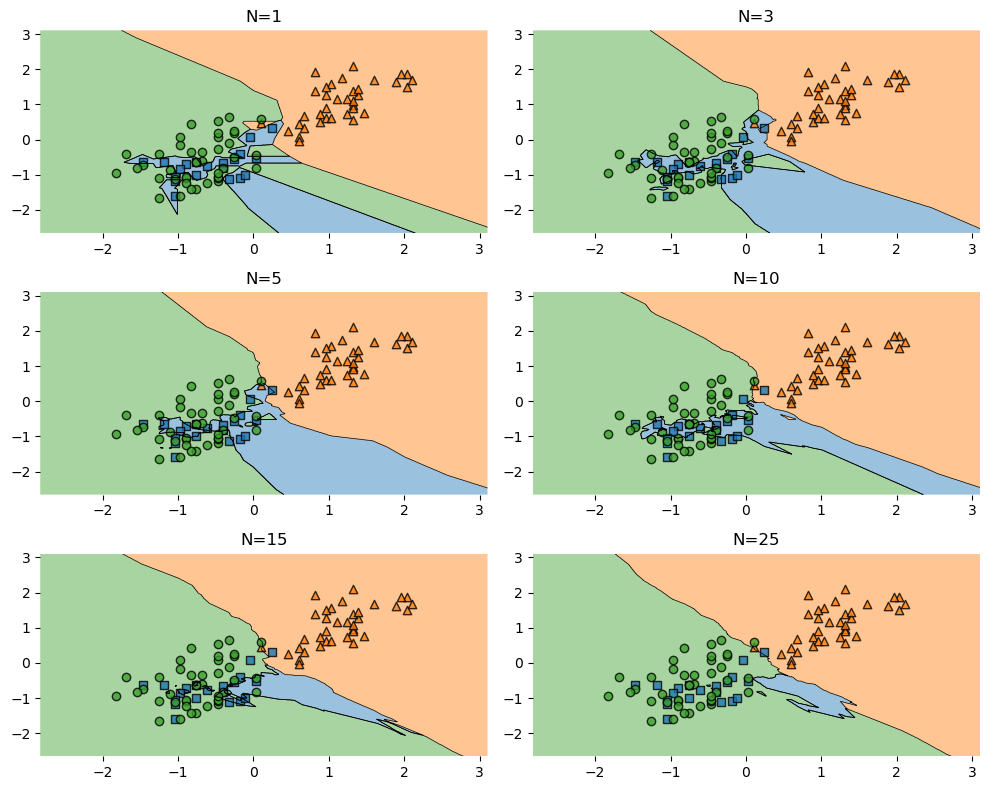

In [16]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

y_train_1d = y_train.ravel().astype(int)

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 2)
coords = [(i, j) for i in range(3) for j in range(2)]
labels = ['N=1','N=3','N=5','N=10','N=15','N=25']

for clf, lab, (i, j) in zip(models, labels, coords):
    ax = plt.subplot(gs[i, j])
    plot_decision_regions(
        X=used_train_data_stand,
        y=y_train_1d,
        clf=clf,
        ax=ax,
        legend=0
    )
    ax.set_title(lab)

plt.tight_layout()
plt.show()



**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

* Наиболее оптимальным кажется N = 5. На графике нет резких разрывов, кроме как в центре, где количество объектов наибольшее и нельзя гарантировать "ровность" областей. В остальном области разделены довольно равномерно,без больших перекосов по площади.Это подтверждают и цифры, приведенные в 1.3. Accuracy при N = 5 кажется наиболее оптимальным
* При N = 1, 3 наблюдаются признаки переобучения (на графиках видно много разрывов, модель часто "высекает линии" в чужой области для определенных элементов). Это подтверждают и значения Accuracy (на обучающей выборке данные довольно близки к единице, тогда как на тестовой результат сильно падает)

### Задание 2. KNN своими руками. 2,5 балла

**Задача 2.1 (2 балла)** В данном задании мы попробуем реализовать алгоритм KNN своими руками, делать мы будем KNN именно для классификации.

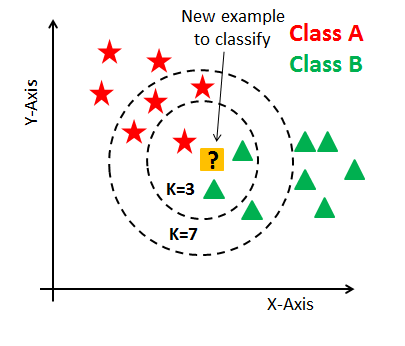

Рекомендации по реализации:
- Используйте `numpy` для представления данных в виде массивов, чтобы минимизировать преобразования.
- Избегайте циклов по всем объектам, по возможности используйте векторизированные операции.
- Обратите внимание на методы [np.linalg.norm()](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) и [np.argsort()](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html), а также на класс `collections.Counter`.
- Особый плюс, если учтёте обработку возможных ошибок.

In [ ]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
        self.k = k

    def fit(self, X, y):

      # YOUR CODE HERE
      # (⌒_⌒;)

      pass

    def predict(self, X):

      # YOUR CODE HERE
      # (＠_＠)

      pass

    def count_distance(self, x, y):

      # YOUR CODE HERE
      # ヽ(♡‿♡)ノ

      pass

In [ ]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [ ]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

**Задача 2.2 (0.5 балла)** Протестируйте ваш алгоритм на данных о пингвинах. Выведите лучший получившийся результат на тестовой выборке.

Лучшее k: 3 с точностью 0.9898 на test.


### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [19]:
data = pd.read_csv('diamonds (1).csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [20]:
data = data.dropna()
print("Isnull значений - ", data.isnull().sum().sum())

data_checked = data.drop('Unnamed: 0', axis= 1)
data_checked.head() #удалили непонятную нумерацию

Isnull значений -  0


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Задача 3.2 (0.2 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Постройте матрицу корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки имеют наибольшую корреляцию с целевой переменной?

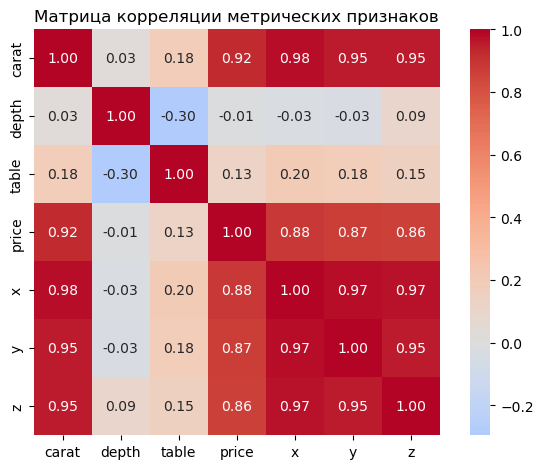

In [21]:
import seaborn as sns

numerious_features = data_checked.select_dtypes(include=[np.number]).columns.tolist()
categorial_features = data_checked.select_dtypes(exclude=[np.number]).columns.tolist()

data_numeric = data[numerious_features]
correlation_matrix = data_numeric.corr()
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f')
plt.title('Матрица корреляции метрических признаков')
plt.tight_layout()
plt.show()

Значения `x`, `y`, `z`, `carat` очень сильно коррелируют со значением таргета `price`. Очень высок риск возникновения мультиколлениарности

**Задача 3.3 (0.2 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные признаки методом OneHot-кодирования (`pd.get_dummies()` или `OneHotEncoder` из `sklearn`).

In [22]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X_reg = data_checked.drop(columns='price')
y_reg = data_checked['price']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, random_state=42, test_size=0.3)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorial_features),
    ],
    remainder='passthrough'  # числовые колонки пропускаем без изменений
)


X_train_coded = preprocessor.fit_transform(X_train_reg)
X_test_coded  = preprocessor.transform(X_test_reg)


feature_names = preprocessor.get_feature_names_out()
X_train_coded_df = pd.DataFrame(X_train_coded, columns=feature_names)
X_test_coded_df  = pd.DataFrame(X_test_coded, columns=feature_names)

X_test_coded_df.head()


,cat__cut_Good,cat__cut_Ideal,cat__cut_Premium,cat__cut_Very Good,cat__color_E,cat__color_F,cat__color_G,cat__color_H,cat__color_I,cat__color_J,cat__clarity_IF,cat__clarity_SI1,cat__clarity_SI2,cat__clarity_VS1,cat__clarity_VS2,cat__clarity_VVS1,cat__clarity_VVS2,remainder__carat,remainder__depth,remainder__table,remainder__x,remainder__y,remainder__z
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.24,62.1,56.0,3.97,4.00,2.47
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.58,60.0,57.0,5.44,5.42,3.26
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.40,62.1,55.0,4.76,4.74,2.95
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.43,60.8,57.0,4.92,4.89,2.98
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.55,62.3,55.0,7.44,7.37,4.61


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [23]:
# не понимаю, зачем сначала делать fit_transform, а потом разбивать


**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче стандартизируйте вещественные признаки в тренировочной и тестовой выборках с помощью `StandardScaler`.

Объясните, как это повлияет на интерпретацию коэффициентов линейной регрессии.

In [24]:

num_idx = [17, 18, 19, 20, 21, 22]
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),num_idx),
    ],
    remainder='passthrough'  # числовые колонки пропускаем без изменений
)
X_train_final = preprocessor2.fit_transform(pd.DataFrame(X_train_coded))
X_test_final = preprocessor2.transform(pd.DataFrame(X_test_coded))

feature_names_final = preprocessor2.get_feature_names_out(X_train_coded_df.columns)

X_train_final_df = pd.DataFrame(X_train_final, columns=feature_names_final)
X_test_final_df  = pd.DataFrame(X_test_final, columns=feature_names_final)

X_test_final_df

,num__remainder__carat,num__remainder__depth,num__remainder__table,num__remainder__x,num__remainder__y,num__remainder__z,remainder__cat__cut_Good,remainder__cat__cut_Ideal,remainder__cat__cut_Premium,remainder__cat__cut_Very Good,remainder__cat__color_E,remainder__cat__color_F,remainder__cat__color_G,remainder__cat__color_H,remainder__cat__color_I,remainder__cat__color_J,remainder__cat__clarity_IF,remainder__cat__clarity_SI1,remainder__cat__clarity_SI2,remainder__cat__clarity_VS1,remainder__cat__clarity_VS2,remainder__cat__clarity_VVS1,remainder__cat__clarity_VVS2
0,-1.177087,0.248547,-0.656213,-1.573073,-1.516519,-1.505623,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.462124,-1.221412,-0.207099,-0.263201,-0.278064,-0.395190,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.840634,0.248547,-1.105327,-0.869128,-0.871127,-0.830930,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.777549,-0.661428,-0.207099,-0.726557,-0.740304,-0.788761,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.577621,0.388543,-1.105327,1.518937,1.422631,1.502385,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16177,-0.819606,-0.381435,0.691128,-0.851307,-0.801355,-0.844986,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16178,0.547234,0.878529,-1.105327,0.672421,0.611531,0.757411,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16179,1.493508,-0.661428,1.140242,1.501116,1.431353,1.347768,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16180,-0.188756,-1.991391,1.589356,0.057584,0.140569,-0.142180,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_final_df, y_train_reg)
y_lr_pred = lr_model.predict(X_test_final_df)

print("MSE on standart Linear Regression:", f"{mean_squared_error(y_true=y_test_reg, y_pred = y_lr_pred):2f}")

MSE on standart Linear Regression: 1244765.435716


**Задача 3.7 (0.3 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [26]:
print("Коэффициенты признаков:", lr_model.coef_)


Коэффициенты признаков: [ 5338.61567061   -90.17381703   -60.33227991 -1100.41885004
    -6.45891672   -34.25894462   595.52108013   846.19625755
   777.76996276   743.30136029  -217.02896774  -273.30397584
  -500.16023818  -998.63466917 -1476.08423332 -2381.98978847
  5459.03729976  3751.70967126  2781.94054814  4657.83430708
  4336.72558298  5101.33518107  5028.29553044]


Наибольшие значения коэффициентов наблюдается при признаках `carat` and `x`

**Задача 3.8 (0.5 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, установив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [27]:
from sklearn.linear_model import Ridge, Lasso

rd_model = Ridge(alpha=10)
rd_model.fit(X_train_final_df, y_train_reg)
y_rd_pred = rd_model.predict(X_test_final_df)

ls_model = Lasso(alpha=10)
ls_model.fit(X_train_final_df, y_train_reg)
y_ls_pred = ls_model.predict(X_test_final_df)

print("MSE on L1: ", mean_squared_error(y_true=y_test_reg, y_pred=y_ls_pred))
print("MSE on L2: ", mean_squared_error(y_true=y_test_reg, y_pred=y_rd_pred))

print("Коэффициенты признаков L1:", ls_model.coef_)
print("Коэффициенты признаков L2:", rd_model.coef_)

MSE on L1:  1464188.7955352117
MSE on L2:  1244928.3665845313
Коэффициенты признаков L1: [ 4.75660219e+03 -1.53122715e+02 -1.09868576e+02 -6.81275333e+02
 -0.00000000e+00 -6.27943894e+00 -0.00000000e+00  1.63904657e+02
  7.66365911e+01  9.09073161e+01  0.00000000e+00 -0.00000000e+00
 -1.29223962e+02 -6.08555564e+02 -9.95890457e+02 -1.78909582e+03
  1.33875782e+03  3.51538125e+00 -8.03616312e+02  8.21889605e+02
  5.69899708e+02  1.17111981e+03  1.16084874e+03]
Коэффициенты признаков L2: [ 5286.2858763    -93.74631385   -63.43010551 -1062.00651417
    -5.91612596   -33.68999395   618.97114817   873.58036919
   801.95061544   773.39019045  -205.01205659  -260.09859655
  -481.91565721  -979.78359673 -1450.00821422 -2345.50521703
  4854.46197243  3193.74171083  2231.68657176  4090.43270419
  3775.03211249  4520.01616636  4454.31581787]


* L1 в силу своей геометрии задавил часть признаков в поисах минимума, остальные коэффициенты тоже поменялись по сравнению с тем, что было в линейке 
* L2 в основном занижал коэфы с целью борьбы с переобучением

**Задача 3.9 (0.5 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод сильнее снижает норму коэффициентов? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

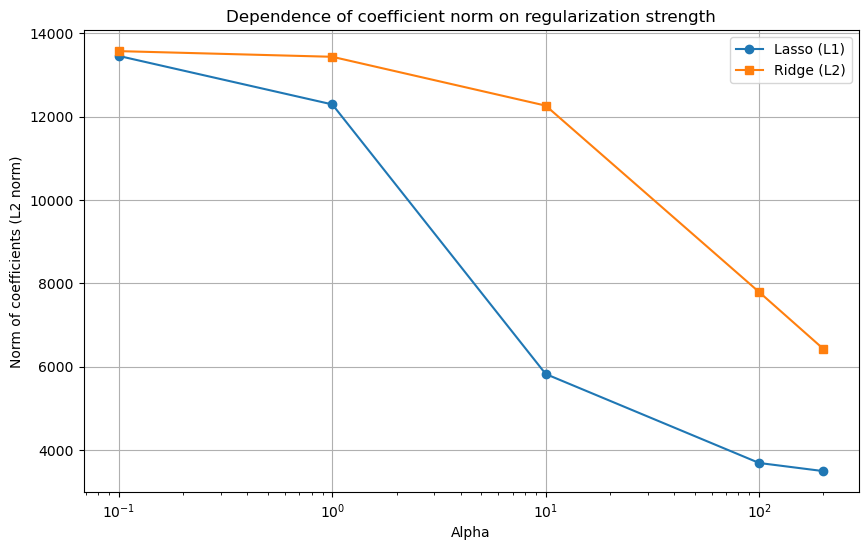

In [28]:
r_results = []
l_results = []
alphas = [0.1, 1, 10, 100, 200]
for a in alphas:
    l_temp = Lasso(alpha=a)
    r_temp = Ridge(alpha=a)

    l_temp.fit(X_train_final_df, y_train_reg)
    r_temp.fit(X_train_final_df, y_train_reg)

    l_results.append(np.linalg.norm(l_temp.coef_))
    r_results.append(np.linalg.norm(r_temp.coef_))



plt.figure(figsize=(10,6))

# Lasso
plt.plot(alphas, l_results, marker='o', label='Lasso (L1)')

# Ridge
plt.plot(alphas, r_results, marker='s', label='Ridge (L2)')

plt.xscale('log')  # альфа обычно отображают в логарифмическом масштабе
plt.xlabel('Alpha')
plt.ylabel('Norm of coefficients (L2 norm)')
plt.title('Dependence of coefficient norm on regularization strength')
plt.legend()
plt.grid(True)
plt.show()

Lasso регуляризация сильнее снижает норму весов. Связано это с геометрией линий уровня MSE и L1. Рассмотри для простоты двумерный случай (два признака). Линии уровня второго образуют октаэдры, с "острыми" углами на осях. Геометрически известен факт, что минимум будет находиться на пересечениях линий уровня, которые находятся в этих самых "острых" углах. Поэтому в поисках минимума мы скорее всего попадем в точку, когда некоторые (в нашем случае один из) признаки будут занулены. Поэтому ее используют часто для отбора признаков

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [53]:
from sklearn.linear_model import LassoCV

las_cv = LassoCV(cv=5, alphas=np.logspace(-4, 2, 200))
las_cv.fit(X_train_final_df, y_train_reg)
print("Значения alpha: ", las_cv.alphas_)
    
print("Средние значения MSE для каждого альфа: ",las_cv.mse_path_.mean(axis=1))

print("Лучшее значение MSE: ", las_cv.mse_path_.mean(axis=1).min())
print("Лучшее alpha:", las_cv.alpha_)


Значения alpha:  [1.00000000e+02 9.32930403e+01 8.70359136e+01 8.11984499e+01
 7.57525026e+01 7.06718127e+01 6.59318827e+01 6.15098579e+01
 5.73844165e+01 5.35356668e+01 4.99450512e+01 4.65952567e+01
 4.34701316e+01 4.05546074e+01 3.78346262e+01 3.52970730e+01
 3.29297126e+01 3.07211300e+01 2.86606762e+01 2.67384162e+01
 2.49450814e+01 2.32720248e+01 2.17111795e+01 2.02550194e+01
 1.88965234e+01 1.76291412e+01 1.64467618e+01 1.53436841e+01
 1.43145894e+01 1.33545156e+01 1.24588336e+01 1.16232247e+01
 1.08436597e+01 1.01163798e+01 9.43787828e+00 8.80488358e+00
 8.21434358e+00 7.66341087e+00 7.14942899e+00 6.66991966e+00
 6.22257084e+00 5.80522552e+00 5.41587138e+00 5.05263107e+00
 4.71375313e+00 4.39760361e+00 4.10265811e+00 3.82749448e+00
 3.57078596e+00 3.33129479e+00 3.10786619e+00 2.89942285e+00
 2.70495973e+00 2.52353917e+00 2.35428641e+00 2.19638537e+00
 2.04907469e+00 1.91164408e+00 1.78343088e+00 1.66381689e+00
 1.55222536e+00 1.44811823e+00 1.35099352e+00 1.26038293e+00
 1.1758

**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [54]:

final_lasso = Lasso(alpha=0.3872038781812553)

final_lasso.fit(X_train_final_df, y_train_reg)
pd.DataFrame(final_lasso.coef_).set_index(X_train_final_df.columns)

,0
num__remainder__carat,5314.642512
num__remainder__depth,-93.654806
num__remainder__table,-62.849143
num__remainder__x,-1086.458810
num__remainder__y,-3.164857
num__remainder__z,-33.048307
remainder__cat__cut_Good,555.373758
remainder__cat__cut_Ideal,807.228199
remainder__cat__cut_Premium,738.501367
remainder__cat__cut_Very Good,706.156923


* В связи со стандартизацией выборки, сложно однозначно интерпетировать данные. Кросс валидация выбрала довольно низкое значение альфа, которое не очень сильно "давит" признаки, поэтому откровенно "отброшенных" признаков не наблюдается.
* Наиболее интересным показалось поведение `x`, `y`, `z`, которые обладали большой мультиколлениарностью. `x` все еще имеет большое значение по модулю, однако при подобранном альфа Лассо все же старается "задавить" `y`/ `z` (при увеличении альфа эти параметры будут стремиться к 0).

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [56]:
y_best_ls_pred = final_lasso.predict(X_test_final_df)

print("MSE on lasso with alpha ~ 0.35: ", mean_squared_error(y_true=y_test_reg, y_pred=y_best_ls_pred))
print("MSE on standart Linear Regression:", f"{mean_squared_error(y_true=y_test_reg, y_pred = y_lr_pred):2f}")

MSE on lasso with alpha ~ 0.35:  1243650.39235016
MSE on standart Linear Regression: 1244765.435716


Модель Lasso с оптимальным значением alpha, подобранным по кросс-валидации, показала немного лучшие результаты на тестовой выборке по сравнению с обычной линейной регрессией.

Это объясняется тем, что исходные признаки обладали высокой мультиколлинеарностью, и L1-регуляризация частично стабилизировала оценки коэффициентов.

Однако выбранный параметр alpha оказался достаточно малым, поэтому Lasso не занулил коррелированные признаки и практически не осуществил жёсткого отбора признаков. С другой стороны, штраф всё же ограничивал рост коэффициентов, что немного снижало переобучение.

В итоге модель улучшилась незначительно. Для более эффективной борьбы с мультиколлинеарностью имеет смысл попробовать L2-регуляризацию (Ridge), которая лучше стабилизирует веса внутри коррелированных групп признаков.